# Random Forest Model - Cloud Resource Forecasting

---

## ⚠️ IMPORTANT: Workflow Changes

**This notebook has been restructured to focus on Direct Prediction Evaluation**

### ✅ Cells to RUN (in order):
1. **Cells 1-5**: Import, Load Data, Configure, Train Models, Load Models from .pkl
2. **Cell 13**: ⚠️ SKIP (Rolling Forecast - commented out)
3. **Cells 14-17**: Direct Prediction Evaluation ← **RUN THESE**
4. **Cells 18+**: ⚠️ SKIP (use forecast_results - commented out)

### ❌ Cells to SKIP:
- Cell 13: Rolling Forecast
- Cell 18+: All cells after Direct Prediction (use forecast_results from rolling forecast)

---

## Objectives

1. **Hyperparameter Tuning**: Grid search for optimal Random Forest parameters
2. **Training**: Fit Random Forest models with high correlation features
3. **Model Saving**: Save trained models to .pkl files
4. **Model Loading**: Load models back from .pkl files
5. **Direct Prediction**: Evaluate model performance without time horizon
6. **Evaluation**: Calculate MAE, RMSE, MAPE, R² metrics

---

**Dataset Info:**
- Time interval: 30 seconds
- Evaluation method: Direct Prediction (no time horizon offset)
- Models: 3 (memory_usage_pct, cpu_total_usage, system_load)
- Method: Random Forest Regressor
- Feature selection: High correlation features from ETL


## 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
import time

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Import model utilities
from model_utils import (
    save_model,
    load_model,
    calculate_metrics,
    print_metrics,
    save_results,
    create_models_directory
)

warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Create models directory
create_models_directory()

print("✓ Libraries imported")
print("✓ Model utilities loaded")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Models directory ready: models
✓ Libraries imported
✓ Model utilities loaded
Analysis started: 2025-11-11 22:16:30


## 2. Load Processed Data


In [2]:
# Load feature metadata
with open('processed_data/feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print("Feature Metadata:")
print("="*80)
for target, info in feature_metadata.items():
    print(f"\n{target}:")
    print(f"  Features: {info['n_features']}")
    print(f"  List: {info['features']}")

# Target variables
target_vars = ['memory_usage_pct', 'cpu_total_usage', 'system_load']

print("\n" + "="*80)
print("✓ Metadata loaded")


Feature Metadata:

memory_usage_pct:
  Features: 7
  List: ['load-15m', 'sys-context-switch-rate', 'cpu-system', 'cpu-user', 'load-5m', 'sys-mem-buffered', 'sys-mem-free']

cpu_total_usage:
  Features: 7
  List: ['sys-context-switch-rate', 'sys-fork-rate', 'sys-interrupt-rate', 'load-15m', 'load-5m', 'disk-io-write', 'sys-mem-available']

system_load:
  Features: 2
  List: ['load-5m', 'load-15m']

✓ Metadata loaded


In [3]:
# Load train/test datasets
datasets = {}

for target in target_vars:
    print(f"\nLoading {target}...")
    
    X_train = pd.read_csv(f'processed_data/{target}/X_train.csv')
    X_test = pd.read_csv(f'processed_data/{target}/X_test.csv')
    y_train = pd.read_csv(f'processed_data/{target}/y_train.csv').squeeze()
    y_test = pd.read_csv(f'processed_data/{target}/y_test.csv').squeeze()
    
    datasets[target] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'features': feature_metadata[target]['features']
    }
    
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test: {X_test.shape}")
    print(f"  y_train: {len(y_train):,} samples")
    print(f"  y_test: {len(y_test):,} samples")

print("\n" + "="*80)
print("✓ All datasets loaded")
print("="*80)



Loading memory_usage_pct...
  X_train: (68599, 7)
  X_test: (17150, 7)
  y_train: 68,599 samples
  y_test: 17,150 samples

Loading cpu_total_usage...
  X_train: (68599, 7)
  X_test: (17150, 7)
  y_train: 68,599 samples
  y_test: 17,150 samples

Loading system_load...
  X_train: (68599, 2)
  X_test: (17150, 2)
  y_train: 68,599 samples
  y_test: 17,150 samples

✓ All datasets loaded


## 3. Random Forest Configuration & Hyperparameter Tuning

Random Forest hyperparameters to tune:
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of trees
- **min_samples_split**: Minimum samples required to split
- **min_samples_leaf**: Minimum samples at leaf node
- **max_features**: Number of features to consider for best split


In [4]:
# Random Forest hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Forecast horizon
FORECAST_HORIZON = 20  # 10 minutes

# Grid search configuration
GRID_SEARCH = True  # Set to False to use default parameters
USE_RANDOMIZED = True  # Use RandomizedSearchCV for faster search
N_ITER = 20  # Number of parameter settings sampled
N_JOBS = -1  # Use all CPU cores
RANDOM_STATE = 42

print("Random Forest Configuration:")
print("="*80)
print(f"Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nGrid search enabled: {GRID_SEARCH}")
print(f"Randomized search: {USE_RANDOMIZED}")
if USE_RANDOMIZED:
    print(f"Iterations: {N_ITER}")
print(f"Forecast horizon: {FORECAST_HORIZON} steps (10 minutes)")
print(f"Random state: {RANDOM_STATE}")
print("="*80)


Random Forest Configuration:
Parameter grid:
  n_estimators: [50, 100, 200]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

Grid search enabled: True
Randomized search: True
Iterations: 20
Forecast horizon: 20 steps (10 minutes)
Random state: 42


## 4. Train Random Forest Models


In [5]:
# Train Random Forest models
rf_models = {}
training_results = {}

print("="*80)
print("TRAINING RANDOM FOREST MODELS")
print("="*80)

for target in target_vars:
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    X_train = datasets[target]['X_train']
    y_train = datasets[target]['y_train']
    
    print(f"Training samples: {len(y_train):,}")
    print(f"Features: {len(X_train.columns)}")
    
    start_time = time.time()
    
    try:
        if GRID_SEARCH:
            rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
            
            if USE_RANDOMIZED:
                print("\nPerforming randomized search...")
                search = RandomizedSearchCV(
                    rf,
                    param_grid,
                    n_iter=N_ITER,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=N_JOBS,
                    verbose=1,
                    random_state=RANDOM_STATE
                )
            else:
                print("\nPerforming grid search...")
                search = GridSearchCV(
                    rf,
                    param_grid,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=N_JOBS,
                    verbose=1
                )
            
            search.fit(X_train, y_train)
            
            best_model = search.best_estimator_
            best_params = search.best_params_
            best_score = -search.best_score_  # Convert to positive MSE
            
            print(f"\n✓ Search completed")
            print(f"  Best parameters: {best_params}")
            print(f"  Best CV MSE: {best_score:.6f}")
            
        else:
            print("\nTraining with default parameters...")
            best_model = RandomForestRegressor(
                n_estimators=100,
                max_depth=20,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS
            )
            best_model.fit(X_train, y_train)
            best_params = {
                'n_estimators': 100,
                'max_depth': 20,
                'min_samples_split': 2,
                'min_samples_leaf': 1,
                'max_features': 'sqrt'
            }
            best_score = None
        
        training_time = time.time() - start_time
        
        # Store model
        rf_models[target] = best_model
        
        # Save model
        print("\nSaving model...")
        model_path = save_model(
            best_model,
            model_name='random_forest',
            target=target,
            config={
                'params': best_params,
                'n_features': len(X_train.columns),
                'features': list(X_train.columns)
            },
            models_dir='models'
        )
        
        training_results[target] = {
            'params': best_params,
            'n_features': len(X_train.columns),
            'n_samples': len(y_train),
            'training_time': training_time,
            'cv_mse': best_score,
            'model_path': model_path
        }
        
        print(f"✓ Training completed in {training_time:.2f}s")
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 5 Important Features:")
        for idx, row in feature_importance.head(5).iterrows():
            print(f"  {row['feature']:30s}: {row['importance']:.4f}")
        
    except Exception as e:
        print(f"✗ Training failed: {str(e)}")
        training_results[target] = {'error': str(e), 'success': False}

print("\n" + "="*80)
print("✓ Training completed and models saved")
print("="*80)


TRAINING RANDOM FOREST MODELS

Target: memory_usage_pct
Training samples: 68,599
Features: 7

Performing randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Search completed
  Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
  Best CV MSE: 0.814783

Saving model...
✓ Model saved: models\random_forest_memory_usage_pct_20251111_221757.pkl
✓ Training completed in 86.89s

Top 5 Important Features:
  cpu-user                      : 0.2255
  load-15m                      : 0.2021
  sys-context-switch-rate       : 0.1884
  sys-mem-free                  : 0.1182
  sys-mem-buffered              : 0.1063

Target: cpu_total_usage
Training samples: 68,599
Features: 7

Performing randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Search completed
  Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 

## 5. Load Trained Models from .pkl Files

Instead of using models directly from memory, load them from saved .pkl files for visualization


In [13]:
# Load trained models from .pkl files
loaded_models = {}
loaded_metadata = {}

print("="*80)
print("LOADING TRAINED MODELS FROM .pkl FILES")
print("="*80)

for target in target_vars:
    if target in training_results and 'model_path' in training_results[target]:
        model_path = training_results[target]['model_path']
        
        print(f"\n{target}:")
        print(f"  Loading from: {model_path}")
        
        try:
            # Load model using model_utils
            model, metadata = load_model(model_path)
            
            loaded_models[target] = model
            loaded_metadata[target] = metadata
            
            print(f"  ✓ Model loaded successfully")
            print(f"  Features: {metadata['config']['n_features']}")
            print(f"  Parameters: {metadata['config']['params']}")
            
        except Exception as e:
            print(f"  ✗ Failed to load: {str(e)}")
    else:
        print(f"\n✗ {target}: No model path found")

print("\n" + "="*80)
print(f"✓ Loaded {len(loaded_models)}/{len(target_vars)} models from .pkl files")
print("="*80)

# Verify we have all models
if len(loaded_models) == len(target_vars):
    print("\n All models loaded successfully! Ready for visualization.")
else:
    print(f"\n Only {len(loaded_models)} models loaded. Check training results.")


LOADING TRAINED MODELS FROM .pkl FILES

memory_usage_pct:
  Loading from: models\random_forest_memory_usage_pct_20251111_221757.pkl
✓ Model loaded: models\random_forest_memory_usage_pct_20251111_221757.pkl
  Model: random_forest
  Target: memory_usage_pct
  Saved at: 2025-11-11 22:17:57
  ✓ Model loaded successfully
  Features: 7
  Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

cpu_total_usage:
  Loading from: models\random_forest_cpu_total_usage_20251111_221930.pkl
✓ Model loaded: models\random_forest_cpu_total_usage_20251111_221930.pkl
  Model: random_forest
  Target: cpu_total_usage
  Saved at: 2025-11-11 22:19:30
  ✓ Model loaded successfully
  Features: 7
  Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

system_load:
  Loading from: models\random_forest_system_load_20251111_221944.pkl
✓ Model loaded: models\random_forest_system_loa

## 6. Multi-Step Forecasting with Loaded Models (OPTIONAL - COMMENTED OUT)

**Note**: Section này sử dụng rolling forecast với time horizon. Đã được comment để tránh nhầm lẫn với Direct Prediction evaluation. Uncomment nếu muốn test forecasting ability.


In [18]:
# COMMENTED OUT - Rolling Forecast with Horizon
# Uncomment this cell if you want to test forecasting ability (predicting future values)

# def rf_rolling_forecast(model, X_test, y_test, horizon=20):
#     """
#     Rolling forecast for Random Forest
#     Predict 'horizon' steps ahead at each time point
#     """
#     n_test = len(y_test)
#     predictions = []
#     
#     # Can only forecast where we have enough future data
#     n_forecast_points = n_test - horizon + 1
#     
#     print(f"  Forecasting {n_forecast_points} points with horizon={horizon}")
#     
#     for i in range(n_forecast_points):
#         # Use features at time t to predict value at time t+horizon
#         X_current = X_test.iloc[i:i+1]
#         pred = model.predict(X_current)[0]
#         predictions.append(pred)
#         
#         if (i + 1) % 5000 == 0:
#             print(f"    Progress: {i+1}/{n_forecast_points}")
#     
#     # Align actual values
#     # FIX: Use horizon-1 to properly align predictions with actual values
#     # i=0: predict for y_test[horizon-1] (step 20 from step 0 = index 19)
#     predictions = np.array(predictions)
#     actual = y_test.iloc[horizon-1:horizon-1+n_forecast_points].values
#     
#     return predictions, actual

# # Perform forecasting
# print("="*80)
# print(f"MULTI-STEP FORECASTING (Horizon: {FORECAST_HORIZON} steps = 10 minutes)")
# print("="*80)

# forecast_results = {}

# for target in target_vars:
#     if target not in loaded_models:
#         print(f"\n✗ Skipping {target} - model not loaded")
#         continue
#     
#     print(f"\n{'='*80}")
#     print(f"Target: {target}")
#     print(f"{'='*80}")
#     
#     # Use LOADED model from .pkl file
#     model = loaded_models[target]
#     X_test = datasets[target]['X_test']
#     y_test = datasets[target]['y_test']
#     
#     start_time = time.time()
#     
#     try:
#         predictions, actual = rf_rolling_forecast(model, X_test, y_test, FORECAST_HORIZON)
#         
#         forecast_time = time.time() - start_time
#         
#         forecast_results[target] = {
#             'predictions': predictions,
#             'actual': actual,
#             'n_predictions': len(predictions),
#             'forecast_time': forecast_time,
#             'horizon': FORECAST_HORIZON
#         }
#         
#         print(f"✓ Completed in {forecast_time:.2f}s")
#         print(f"  Predictions: {len(predictions):,}")
#         print(f"  Avg time: {forecast_time/len(predictions)*1000:.2f}ms per forecast")
#         
#     except Exception as e:
#         print(f"✗ Forecasting failed: {str(e)}")
#         forecast_results[target] = {'error': str(e), 'success': False}

# print("\n" + "="*80)
# print("✓ Forecasting completed")
# print("="*80)

print("⚠️  Rolling Forecast section is commented out. Using Direct Prediction instead.")


⚠️  Rolling Forecast section is commented out. Using Direct Prediction instead.


## 7. Direct Prediction (No Horizon) - Model Evaluation

Đánh giá model bằng cách predict trực tiếp trên test set (không có time horizon offset)


In [29]:
# Direct prediction - no time horizon offset
print("="*80)
print("DIRECT PREDICTION EVALUATION (No Time Horizon)")
print("Predict value at time t using features at time t")
print("="*80)

direct_pred_results = {}

for target in target_vars:
    
    if target not in loaded_models:
        print(f"\n✗ Skipping {target} - model not loaded")
        continue
    
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    model = loaded_models[target]
    X_test = datasets[target]['X_test']
    y_test = datasets[target]['y_test']
    
    start_time = time.time()
    
    try:
        # Direct prediction: use X_test to predict y_test directly
        predictions = model.predict(X_test)
        
        pred_time = time.time() - start_time
        
        # Calculate metrics
        metrics = calculate_metrics(y_test.values, predictions)
        
        direct_pred_results[target] = {
            'predictions': predictions,
            'actual': y_test.values,
            'n_predictions': len(predictions),
            'prediction_time': pred_time,
            'metrics': metrics
        }
        
        print(f"✓ Completed in {pred_time:.2f}s")
        print(f"  Predictions: {len(predictions):,}")
        print(f"  Avg time: {pred_time/len(predictions)*1000:.4f}ms per prediction")
        print(f"\n  Metrics:")
        print(f"    MAE:  {metrics['mae']:.6f}")
        print(f"    RMSE: {metrics['rmse']:.6f}")
        print(f"    MAPE: {metrics['mape']:.2f}%")
        print(f"    R²:   {metrics['r2']:.6f}")
        
    except Exception as e:
        print(f"✗ Prediction failed: {str(e)}")
        direct_pred_results[target] = {'error': str(e), 'success': False}

print("\n" + "="*80)
print("✓ Direct prediction evaluation completed")
print("="*80)


DIRECT PREDICTION EVALUATION (No Time Horizon)
Predict value at time t using features at time t

Target: memory_usage_pct
✓ Completed in 0.02s
  Predictions: 17,150
  Avg time: 0.0013ms per prediction

  Metrics:
    MAE:  0.975521
    RMSE: 1.096536
    MAPE: 233.71%
    R²:   -0.535724

Target: cpu_total_usage
✓ Completed in 0.28s
  Predictions: 17,150
  Avg time: 0.0161ms per prediction

  Metrics:
    MAE:  0.170615
    RMSE: 0.445639
    MAPE: 80.38%
    R²:   0.792355

Target: system_load
✓ Completed in 0.03s
  Predictions: 17,150
  Avg time: 0.0017ms per prediction

  Metrics:
    MAE:  0.263321
    RMSE: 0.467283
    MAPE: 458.18%
    R²:   0.772278

✓ Direct prediction evaluation completed


In [30]:
# Summary of Direct Prediction Results
print("\n" + "="*80)
print("DIRECT PREDICTION EVALUATION SUMMARY")
print("="*80)

print(f"\n{'Target':<20} {'MAE':>12} {'RMSE':>12} {'MAPE':>12} {'R²':>12}")
print("-" * 70)

for target in target_vars:
    if target in direct_pred_results and 'metrics' in direct_pred_results[target]:
        metrics = direct_pred_results[target]['metrics']
        print(f"{target:<20} {metrics['mae']:>12.6f} {metrics['rmse']:>12.6f} "
              f"{metrics['mape']:>12.2f}% {metrics['r2']:>12.6f}")

print("\n" + "="*80)
print("Interpretation:")
print("- Direct Prediction evaluates model's ability to fit the data")
print("- Higher R² (closer to 1.0) = better fit")
print("- Lower MAE/RMSE = more accurate predictions")
print("="*80)

# # COMMENTED OUT - Comparison with Rolling Forecast
# # Uncomment if you want to compare with forecasting results
# comparison_data = []
# for target in target_vars:
#     if target in direct_pred_results and target in forecast_results:
#         direct_metrics = direct_pred_results[target]['metrics']
#         forecast_metrics = evaluation_results.get(target, {})
#         
#         if forecast_metrics:
#             comparison_data.append({
#                 'target': target,
#                 'direct_mae': direct_metrics['mae'],
#                 'forecast_mae': forecast_metrics['mae'],
#                 'direct_r2': direct_metrics['r2'],
#                 'forecast_r2': forecast_metrics['r2']
#             })



DIRECT PREDICTION EVALUATION SUMMARY

Target                        MAE         RMSE         MAPE           R²
----------------------------------------------------------------------
memory_usage_pct         0.975521     1.096536       233.71%    -0.535724
cpu_total_usage          0.170615     0.445639        80.38%     0.792355
system_load              0.263321     0.467283       458.18%     0.772278

Interpretation:
- Direct Prediction evaluates model's ability to fit the data
- Higher R² (closer to 1.0) = better fit
- Lower MAE/RMSE = more accurate predictions


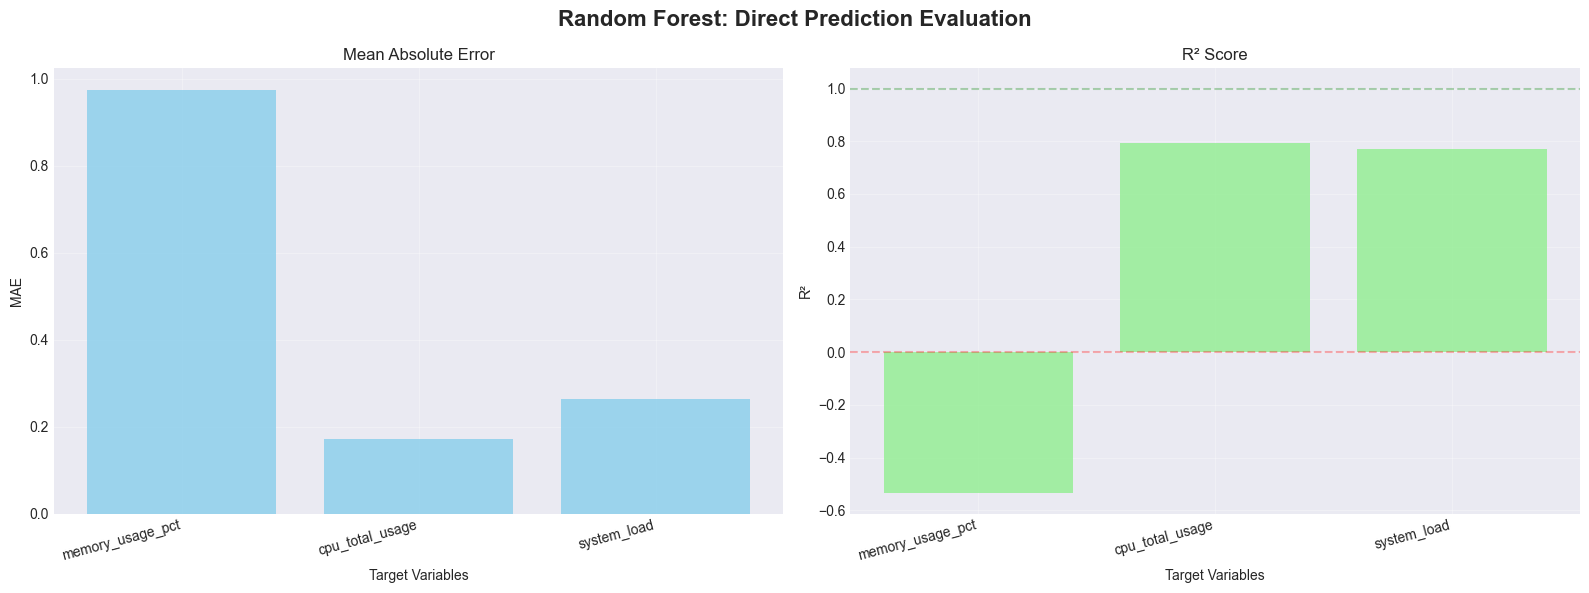

In [31]:
# Visualize Direct Prediction Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Forest: Direct Prediction Evaluation', fontsize=16, fontweight='bold')

targets = []
mae_vals = []
r2_vals = []

for target in target_vars:
    if target in direct_pred_results and 'metrics' in direct_pred_results[target]:
        targets.append(target)
        mae_vals.append(direct_pred_results[target]['metrics']['mae'])
        r2_vals.append(direct_pred_results[target]['metrics']['r2'])

x = np.arange(len(targets))

# MAE plot
axes[0].bar(x, mae_vals, alpha=0.8, color='skyblue')
axes[0].set_xlabel('Target Variables')
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xticks(x)
axes[0].set_xticklabels(targets, rotation=15, ha='right')
axes[0].grid(True, alpha=0.3)

# R² plot
axes[1].bar(x, r2_vals, alpha=0.8, color='lightgreen')
axes[1].set_xlabel('Target Variables')
axes[1].set_ylabel('R²')
axes[1].set_title('R² Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(targets, rotation=15, ha='right')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[1].axhline(y=1, color='g', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# # COMMENTED OUT - Comparison visualization
# # Uncomment to show comparison with forecast results
# if comparison_data:
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#     fig.suptitle('Random Forest: Direct Prediction vs Forecast Comparison', fontsize=16, fontweight='bold')
#     ...
#     plt.show()


In [24]:
# COMMENTED OUT - This cell uses forecast_results from rolling forecast
# Uncomment if you uncomment the rolling forecast section

# # Calculate metrics
# print("="*80)
# print("EVALUATION METRICS")
# print("="*80)

# evaluation_results = {}

# for target in target_vars:
#     if target not in forecast_results or 'predictions' not in forecast_results[target]:
#         print(f"\n✗ Skipping {target} - no predictions")
#         continue
#     
#     print(f"\n{'='*80}")
#     print(f"Target: {target}")
#     print(f"{'='*80}")
#     
#     y_true = forecast_results[target]['actual']
#     y_pred = forecast_results[target]['predictions']
#     
#     # Calculate metrics
#     metrics = calculate_metrics(y_true, y_pred)
#     evaluation_results[target] = metrics
#     
#     # Print formatted metrics
#     print_metrics(metrics, target)

# print("\n" + "="*80)
# print("✓ Evaluation completed")
# print("="*80)

print("⚠️  This section uses rolling forecast results (commented out).")


⚠️  This section uses rolling forecast results (commented out).


## 8. Visualizations (COMMENTED OUT - uses rolling forecast results)

**Note**: Các cells visualization dưới đây sử dụng rolling forecast results đã bị comment.


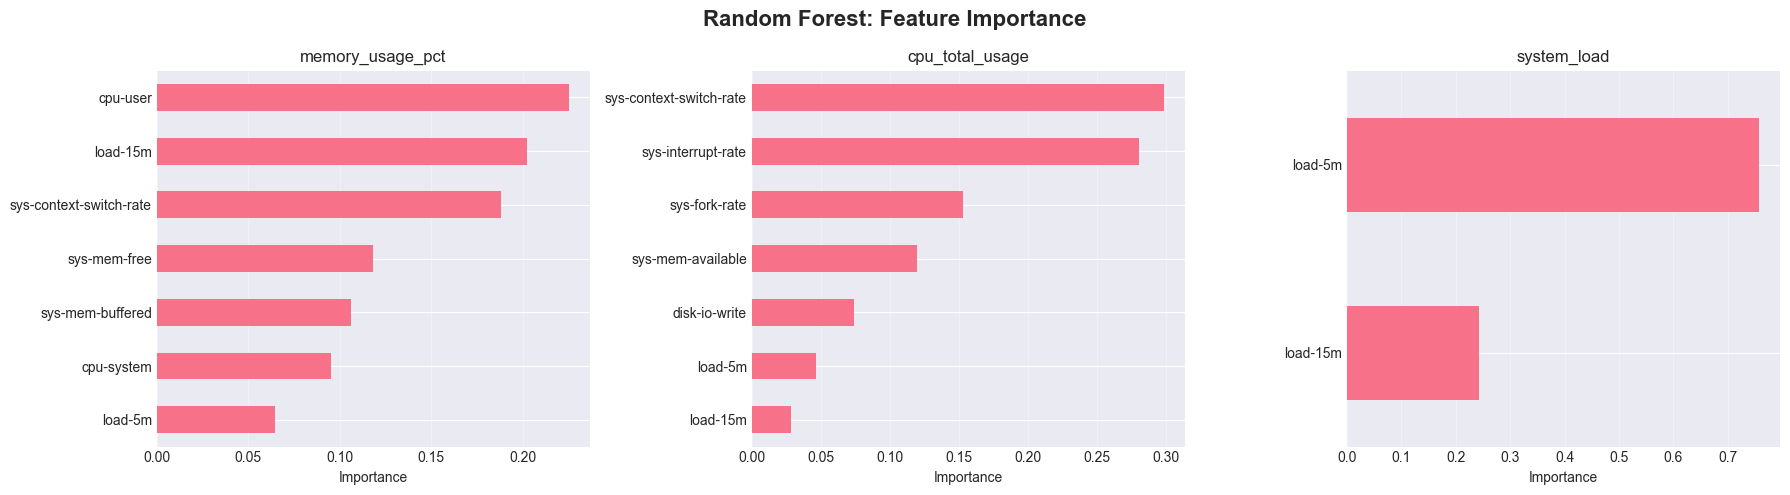

In [25]:
# Plot feature importance for all targets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Random Forest: Feature Importance', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    if target not in loaded_models:
        continue
    
    # Use LOADED model from .pkl file
    model = loaded_models[target]
    X_train = datasets[target]['X_train']
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    # Plot
    importance_df.plot(kind='barh', x='feature', y='importance', ax=axes[idx], legend=False)
    axes[idx].set_title(f'{target}')
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('')
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 8. Visualizations (COMMENTED OUT - uses forecast results)

**Note**: Sections dưới đây sử dụng kết quả từ rolling forecast đã bị comment.


KeyError: 'memory_usage_pct'

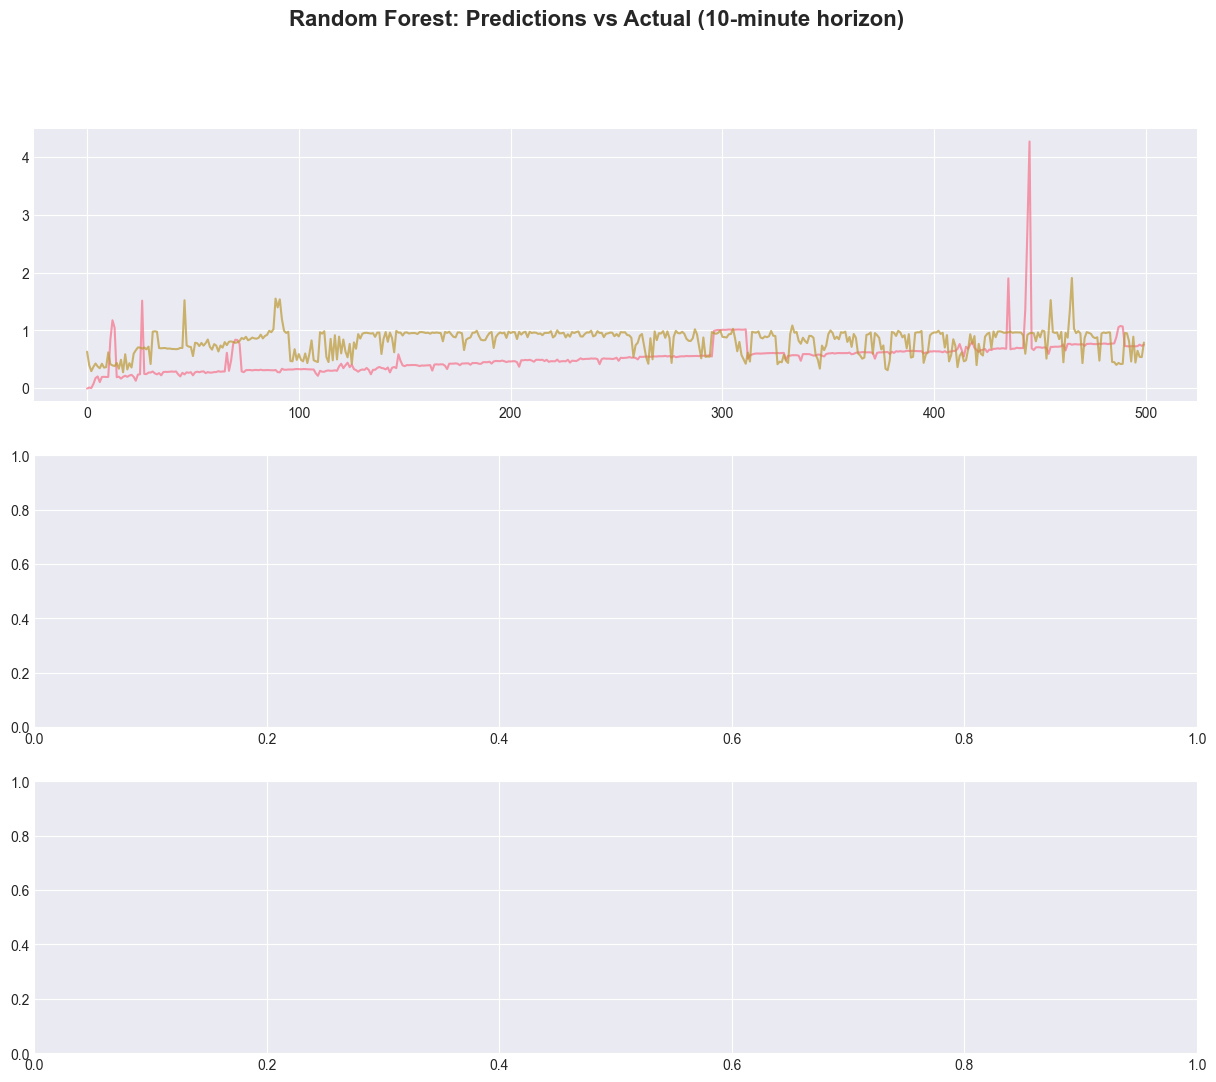

In [32]:
# Plot predictions vs actual
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Random Forest: Predictions vs Actual (10-minute horizon)', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    if target not in forecast_results or 'predictions' not in forecast_results[target]:
        continue
    
    y_true = forecast_results[target]['actual']
    y_pred = forecast_results[target]['predictions']
    
    # Plot first 500 points
    n_plot = min(500, len(y_true))
    
    axes[idx].plot(y_true[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
    axes[idx].plot(y_pred[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
    axes[idx].set_title(f'{target} - MAE: {evaluation_results[target]["mae"]:.4f}, R²: {evaluation_results[target]["r2"]:.4f}')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Normalized Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ValueError: x and y must be the same size

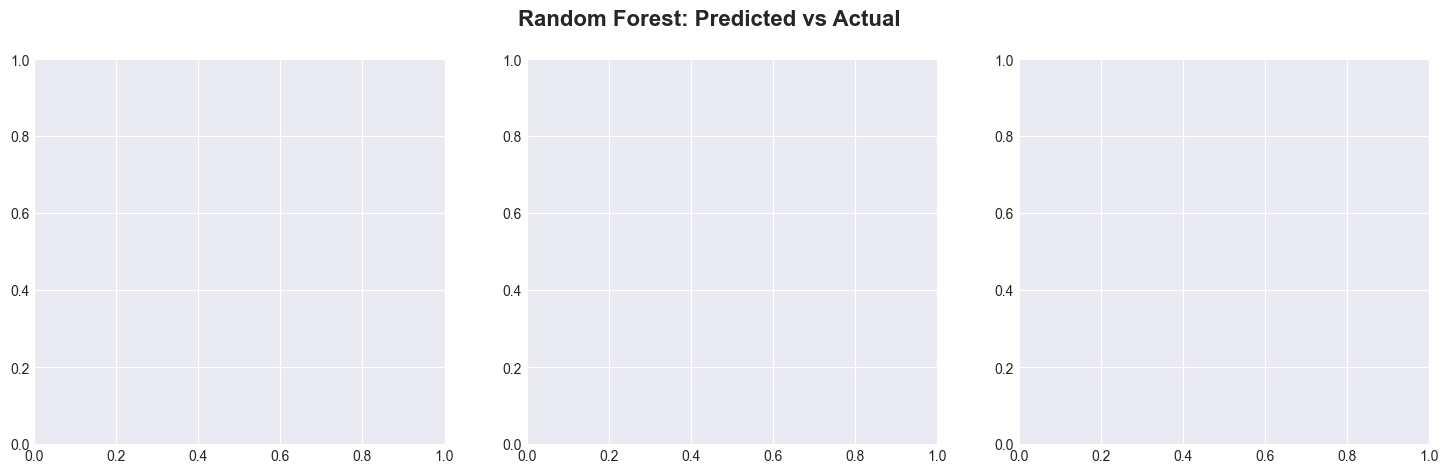

In [28]:
# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Random Forest: Predicted vs Actual', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    if target not in forecast_results or 'predictions' not in forecast_results[target]:
        continue
    
    y_true = forecast_results[target]['actual']
    y_pred = forecast_results[target]['predictions']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    
    axes[idx].set_title(f'{target}\\nR² = {evaluation_results[target]["r2"]:.4f}')
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Metrics comparison
metrics_df = pd.DataFrame(evaluation_results).T

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Random Forest Performance Metrics', fontsize=16, fontweight='bold')

metrics_df['mae'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True, alpha=0.3)

metrics_df['rmse'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('RMSE')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True, alpha=0.3)

metrics_df['mape'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('MAPE')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

metrics_df['r2'].plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R²')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Save Results


In [ ]:
# Compile results
final_results = {
    'model': 'Random Forest',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'forecast_horizon': FORECAST_HORIZON,
    'forecast_horizon_minutes': FORECAST_HORIZON * 0.5,
    'targets': {}
}

for target in target_vars:
    if target not in evaluation_results:
        continue
    
    final_results['targets'][target] = {
        'model_config': {
            'params': training_results[target]['params'],
            'n_features': training_results[target]['n_features']
        },
        'training': {
            'samples': training_results[target]['n_samples'],
            'time_seconds': training_results[target]['training_time'],
            'cv_mse': training_results[target].get('cv_mse'),
            'model_path': training_results[target]['model_path']
        },
        'forecasting': {
            'n_predictions': forecast_results[target]['n_predictions'],
            'time_seconds': forecast_results[target]['forecast_time']
        },
        'metrics': evaluation_results[target]
    }

# Save results
output_file = save_results(final_results, 'results_random_forest.json')

print("="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"Model: Random Forest")
print(f"Forecast horizon: {FORECAST_HORIZON} steps ({FORECAST_HORIZON*0.5:.1f} min)")
print(f"Results saved to: {output_file}")
print(f"Models saved in: models/")

print(f"\nMetrics Overview:")
for target in target_vars:
    if target in final_results['targets']:
        metrics = final_results['targets'][target]['metrics']
        print(f"\n  {target}:")
        print(f"    MAE:  {metrics['mae']:.6f}")
        print(f"    RMSE: {metrics['rmse']:.6f}")
        print(f"    R²:   {metrics['r2']:.6f}")

print("="*80)


## 10. Test with Different Horizons


In [ ]:
# Test with multiple horizons
HORIZONS_TO_TEST = [60]  # 5, 10, 20, 30 minutes

print("="*80)
print("TESTING MULTIPLE HORIZONS")
print("="*80)
print(f"Horizons: {HORIZONS_TO_TEST} steps = {[h*0.5 for h in HORIZONS_TO_TEST]} minutes")
print()

horizon_comparison = {}

for target in target_vars:
    if target not in loaded_models:
        continue
    
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    # Use LOADED model from .pkl file
    model = loaded_models[target]
    X_test = datasets[target]['X_test']
    y_test = datasets[target]['y_test']
    
    horizon_comparison[target] = {}
    
    for horizon in HORIZONS_TO_TEST:
        print(f"  Horizon: {horizon} steps ({horizon*0.5:.1f} min)... ", end='')
        
        try:
            predictions, actual = rf_rolling_forecast(model, X_test, y_test, horizon)
            metrics = calculate_metrics(actual, predictions)
            
            horizon_comparison[target][f"h{horizon}"] = {
                'horizon': horizon,
                'horizon_minutes': horizon * 0.5,
                'n_predictions': len(predictions),
                'metrics': metrics
            }
            
            print(f"MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
            
        except Exception as e:
            print(f"Failed: {str(e)}")

print("\n" + "="*80)
print("✓ Horizon testing completed")
print("="*80)


In [ ]:
# Comparison table
print("\nHORIZON COMPARISON:")
print("="*80)

for target in target_vars:
    if target not in horizon_comparison:
        continue
    
    print(f"\n{target.upper()}:")
    print(f"{'Horizon':>10} {'Minutes':>10} {'MAE':>12} {'RMSE':>12} {'R²':>12}")
    print("-" * 80)
    
    for h_key in sorted(horizon_comparison[target].keys(),
                       key=lambda x: horizon_comparison[target][x]['horizon']):
        h = horizon_comparison[target][h_key]
        print(f"{h['horizon']:>10} {h['horizon_minutes']:>10.1f} "
              f"{h['metrics']['mae']:>12.6f} {h['metrics']['rmse']:>12.6f} "
              f"{h['metrics']['r2']:>12.6f}")


In [ ]:
# Visualize performance vs horizon
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Random Forest: Performance vs Forecast Horizon', fontsize=16, fontweight='bold')

metrics_to_plot = ['mae', 'rmse', 'mape', 'r2']
titles = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
colors_list = ['skyblue', 'lightcoral', 'lightgreen']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for cidx, target in enumerate(target_vars):
        if target not in horizon_comparison:
            continue
        
        horizons = []
        values = []
        
        for h_key in sorted(horizon_comparison[target].keys(),
                           key=lambda x: horizon_comparison[target][x]['horizon']):
            h = horizon_comparison[target][h_key]
            horizons.append(h['horizon_minutes'])
            values.append(h['metrics'][metric])
        
        ax.plot(horizons, values, marker='o', linewidth=2,
               label=target, alpha=0.7, color=colors_list[cidx])
    
    ax.set_title(title)
    ax.set_xlabel('Horizon (minutes)')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if metric == 'r2':
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Save horizon comparison
horizon_results = {
    'model': 'Random Forest',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'horizons_tested': HORIZONS_TO_TEST,
    'targets': horizon_comparison
}

horizon_file = save_results(horizon_results, 'results_random_forest_horizon_comparison.json')

print("\nBest horizon by MAE:")
for target in target_vars:
    if target in horizon_comparison:
        best = min(horizon_comparison[target].items(),
                  key=lambda x: x[1]['metrics']['mae'])
        print(f"  {target}: {best[1]['horizon']} steps ({best[1]['horizon_minutes']:.1f} min) "
              f"- MAE: {best[1]['metrics']['mae']:.6f}")

print(f"\n✓ Horizon comparison saved to: {horizon_file}")
